# Figure notebook

Unreported boards (BibTex key, board, reason to not report)

- martinsRealtimeSVMbasedHardware2024, Cyclone V, "embedded system with an ARM Cortex-A9 integrated with Cyclone V SoC" + they get worse performance
- rapuanoFPGAbasedHardwareAccelerator2021a, Kintex US rad-hard (XQRKU060), don't report total power + half the frequency and double the latency + They use ZU7EV as a development board
- heConfigurable2D3D2023a, Zynq 7000 (Z7020) {Zedboard}, only ran HybridSN on it + lower-cost and less resources
- gargAircraftDetectionSatellite2024, Kintex Ultrascale(KU040), 0 details about it, just report lower FPS than the Zynq US+
- sabogalMethodologyEvaluatingAnalyzing2021a, Zynq Z7020, experiment same than their Zynq US+, no more details


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from utils.metadata import fpga_part_info, plot_colors
from pathlib import Path
import pandas as pd

# Quick ANSI color code shortcuts
r = "\033[31m"
y = "\033[33m"
g = "\033[32m"
b = "\033[34m"
e = "\033[0m"

pickleName = "all_datapoints.pkl"
datapointsDfPath = Path("..") / "data" / "Dataframes" / pickleName
datapointsDf = pd.read_pickle(datapointsDfPath)

In [4]:
# ----- Manually add the unreported FPGAs, available through the Tag "Other: (Unreported board): <family/serie>") -----
# Cyclone 5, Kintex US rad hard , Zynq 7000, Kintex US (KU040) , Z-7
unreportedFPGAS = ["5CSEMA5F31C6", "XQRKU060" , "XC7Z020","XCKU040","XC7Z020"]
print(fpga_part_info)
print(plot_colors)

def get_part(board_str):
    tag =  board_str.split("(")[0]
    board = board_str.split("{")[1].split("}")[0]
    part = board_str.split("(")[1].split(")")[0]
    if(board.endswith("KV260")):
        part = "XCK26"
    return part, board

# ----- Build a dictionary with the parts and their quantities -----
def add_part(parts, p):
    if p not in fpga_part_info:
        print(f"Warning: {p} not found in fpga_part_info")
        return
    if p in parts.keys():
        parts[p]["quantity"] += 1
    else:
        parts[p] = {}
        parts[p]["quantity"] = 1
        parts[p]["year"]    = fpga_part_info[p][0]
        parts[p]["DSP"]     = fpga_part_info[p][1]
        parts[p]["family"]  = fpga_part_info[p][2]

parts_info = {}
# For all article (i.e., unique experiment)
for k in datapointsDf["BBT Citation Key"].unique():
    df = datapointsDf[datapointsDf["BBT Citation Key"] == k]
    for board in df["Board"].unique():
        p, b = get_part(board)
        add_part(parts_info, p)
# And for the unreported FPGAs
for p in unreportedFPGAS:
    add_part(parts_info, p)
parts_info = {k: v for k, v in sorted(parts_info.items(), key=lambda item: item[1]["quantity"],reverse=True)}

fcolors = {
    "Zynq":     plot_colors["blue_1"],
    "Artix":    plot_colors["green_1"],
    "Kria":     plot_colors["red_1"],
    "Spartan":  plot_colors["dark_gray"],
    "Virtex":   plot_colors["teal_2"],
    "Kintex":   plot_colors["green_2"],
    "Alveo":    plot_colors["red_3"],
    "Cyclone":  plot_colors["gray"],
}

def support_labels(ax, start_pos, mid_pos, end_pos, label, circle_pos, color='gray', fontsize=18):
    """
    Draw two line segments (like a 'powerpoint' arrow) and place a text label.

    Parameters:
    ax         : Matplotlib axes
    start_pos  : tuple (dx, dy) relative to circle_pos for the label's location
    mid_pos    : tuple (dx, dy) where the first line turns
    end_pos    : tuple (dx, dy) where the second line ends (on circle edge, etc.)
    label      : text to draw
    circle_pos : tuple (x_center, y_center) absolute position of the circle center
    """
    # Compute absolute positions
    sx, sy = circle_pos[0] + start_pos[0], circle_pos[1] + start_pos[1]
    mx, my = circle_pos[0] + mid_pos[0],  circle_pos[1] + mid_pos[1]
    ex, ey = circle_pos[0] + end_pos[0],  circle_pos[1] + end_pos[1]

    # Draw lines
    ax.plot([sx, mx], [sy, my], color=color, lw=3)
    ax.plot([mx, ex], [my, ey], color=color, lw=3)

    # Place label near the start point
    text_anchor = 'left' if start_pos[0] < 0 else 'right'
    ax.text(sx, sy + 0.01, label, ha=text_anchor, va='bottom', fontsize=fontsize)

{'XC3SD1800A': [2006, 84, 'Spartan'], 'XC6VLX240T': [2009, 768, 'Virtex'], 'XC7A35T': [2010, 90, 'Artix'], 'XC7A200T': [2010, 740, 'Artix'], 'XC7K325T': [2010, 840, 'Kintex'], 'XC7VX690T': [2010, 3600, 'Virtex'], 'XC7Z020': [2011, 220, 'Zynq'], 'XC7Z035': [2011, 900, 'Zynq'], 'XC7Z045': [2011, 900, 'Zynq'], 'XC7Z100': [2011, 2020, 'Zynq'], 'XCKU040': [2013, 1920, 'Kintex'], 'XQRKU060': [2018, 2760, 'Kintex'], 'XCZU9EG': [2015, 2520, 'Zynq'], 'XCZU15EG': [2015, 3528, 'Zynq'], 'XCZU19EG': [2015, 1968, 'Zynq'], 'XCZU3EG': [2015, 360, 'Zynq'], 'XCZU7EV': [2015, 1728, 'Zynq'], 'U280': [2018, 9024, 'Alveo'], 'XCK26': [2021, 1248, 'Kria'], '5CSXC6': [2012, 112, 'Cyclone'], '5CSEMA5F31C6': [2012, 87, 'Cyclone']}
{'mpl_blue': '#1f77b4', 'blue_1': '#2066a8', 'blue_2': '#4B93BA', 'blue_3': '#8cc5e3', 'blue_4': '#AFD8ED', 'red_1': '#A71313', 'red_2': '#af2c2c', 'red_3': '#c46666', 'red_4': '#E18A8A', 'red_5': '#F7ABAB', 'green_1': '#389339', 'green_2': '#58b459', 'green_3': '#83d984', 'green_4': '

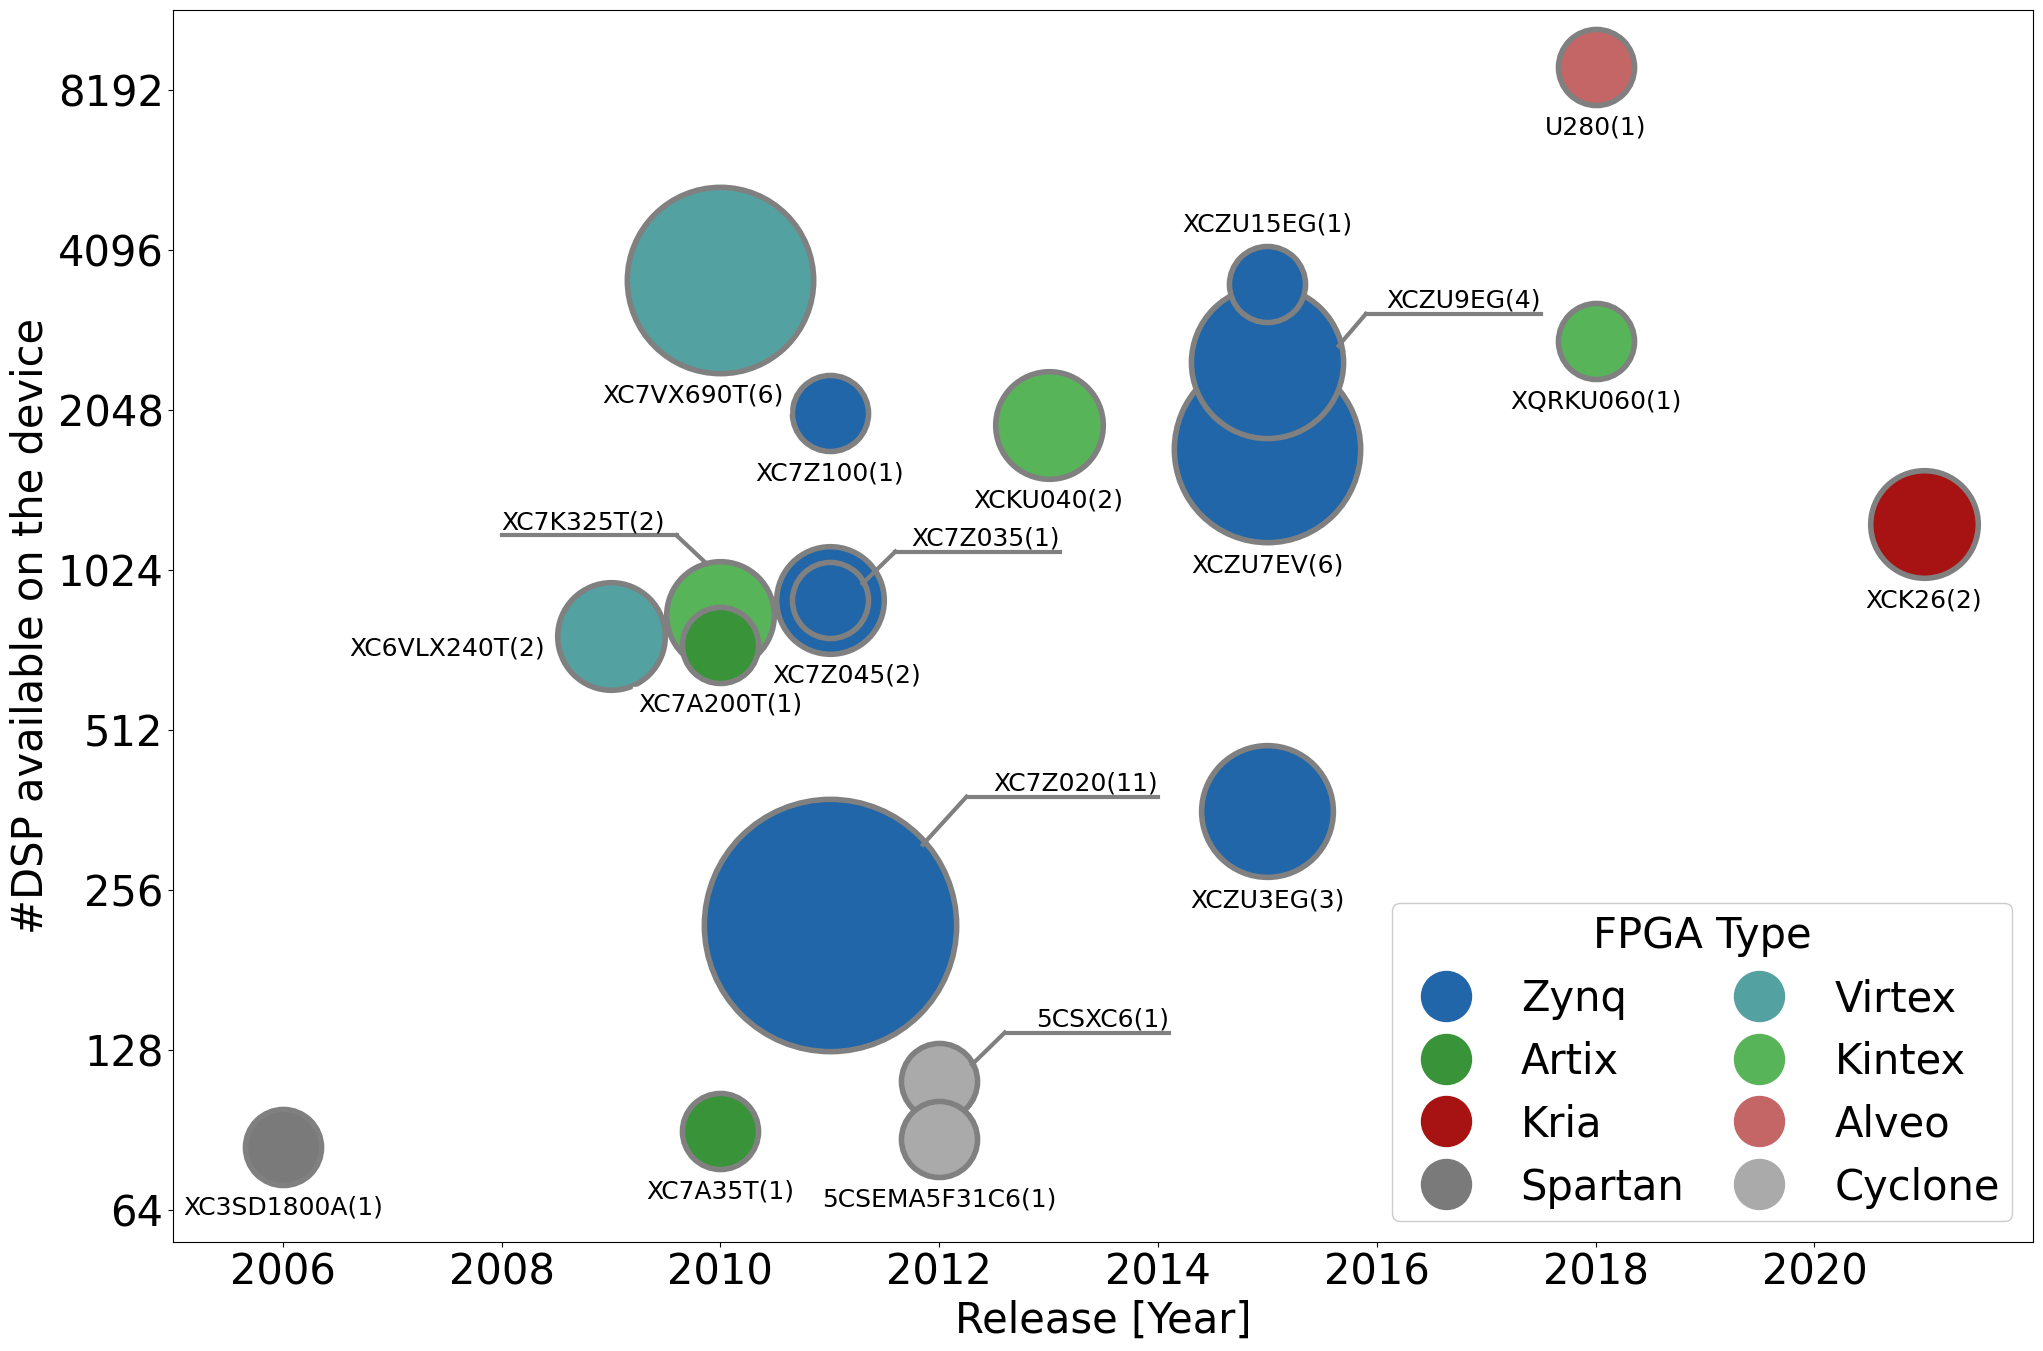

Intel Cyclone boards: 2 (4.00%)
Boards with more than 500 DSPs: 32 (64.00%)


In [5]:
plt.rcParams.update({'font.size': 30})

# Create a figure and a single axes using a more standard approach
fig = plt.figure(figsize=(24, 16))
ax = fig.add_subplot(111)

label_offsets = {
    1: 0.3,
    2: 0.4,
    3: 0.48,
    4: 0,
    6: 0.65,
    # Add more mappings as needed
}

for k, v in parts_info.items():
    x = v["year"]
    y = np.log2(v["DSP"])
    r = v["quantity"]
    label = k + "(" + str(r) + ")"
    x_offset = 0
    y_offset = label_offsets.get(r, 0.25)  # default offset if r isn't in offsets

    ax.scatter(x, y, r*3000, ec="gray", lw=4, c=fcolors[v["family"]])

    if k == "XCZU15EG":
        y_offset = -0.45
    elif k == "XC7VX690T":
        x_offset = 0.25
    elif k == "XC7Z045":
        x_offset = -0.15
    elif k == "XC6VLX240T":
        x_offset = 1.5
        y_offset = 0
    # Top right
    elif k == "5CSXC6" or k == "XC7Z035":
        support_labels(ax, [2.1, 0.3], [0.6, 0.3], [0.3, 0.1], label, [x, y])
        continue
    elif k == "XCZU9EG":
        support_labels(ax, [2.5, 0.3], [0.9, 0.3], [0.65, 0.1], label, [x, y])
        continue
    elif k == "XC7Z020":
        support_labels(ax, [3, 0.8], [1.25, 0.8], [0.85, 0.5], label, [x, y])
        continue
    # Top left
    elif k == "XC7K325T":
        support_labels(ax, [-2, 0.5], [-0.4, 0.5], [-0.12, 0.32], label, [x, y])
        continue

    ax.text(
        x - x_offset,
        y - y_offset,
        label,
        fontsize=18,
        ha="center",
        va="top",
        backgroundcolor="w"
    )

handles = []
for key, color in fcolors.items():
    handles.append(
        plt.Line2D(
            [0], [0],
            color=color,
            linewidth=0,
            linestyle='-',
            label=key,
            marker="o",
            markersize=36
        )
    )

# Legend in bottom-right, slightly above the axis
fig.legend(
    title="FPGA Type",
    handles=handles,
    loc='lower right',
    bbox_to_anchor=(0.9, 0.11),  # move legend above the bottom edge
    framealpha=1,
    labelspacing=0.5,
    borderpad=0.3,
    handleheight=0.8,
    columnspacing=0.8,
    ncols=2
)

yt = [str(2**f) for f in range(6, 14)]
ax.set_yticks(range(6, 14), yt)
ax.set_ylim(5.8, 13.5)
ax.set_ylabel("#DSP available on the device")

xt = np.arange(2006, 2022, 2)
ax.set_xticks(xt, xt)
ax.set_xlim(2005, 2022)
ax.set_xlabel("Release [Year]")

plt.show()

# ----- Quick statistics -----
# Print percent of boards that are not AMD, i.e., Intel Cyclone boards that start with "5CS"
total = sum([v["quantity"] for k, v in parts_info.items()])
intel = sum([v["quantity"] for k, v in parts_info.items() if k.startswith("5CS")])
print(f"Intel Cyclone boards: {intel} ({intel/total*100:.2f}%)")
# Print how many boards have more than 500 DSPs
high_dsp = sum([v["quantity"] for k, v in parts_info.items() if v["DSP"] > 500])
print(f"Boards with more than 500 DSPs: {high_dsp} ({high_dsp/total*100:.2f}%)")